In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import wandb
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(project_root)

from models.AutoEncoders.cnn_autoencoder import CnnAutoencoder
from models.pca.pca import PCA

from performance_measures.metrics import Metrics
from models.MLP.MLP import MLP_Classifier
from performance_measures import metrics as metrics1
from models.MLP.MLP import MLP_Regression
from models.AutoEncoders.AutoEncoders import AutoEncoder
from models.knn.knn import KNN


# 4.2 CNN AutoEncoder

## 4.2.1

In [2]:

def data_splits():

    # Paths to the CSV files
    train_path = '../../data/interim/4/fashion_mnist/fashion-mnist_train.csv'
    test_path = '../../data/interim/4/fashion_mnist/fashion-mnist_test.csv'

    # Load the CSV files
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    # Get the number of data points in each file
    train_size = train_data.shape[0]
    test_size = test_data.shape[0]

    print(f"Number of data points in the training file: {train_size}")
    print(f"Number of data points in the test file: {test_size}")


    # Split the dataset into 50,000 for training and 10,000 for validation
    train_data_split = train_data[:50000]
    val_data_split = train_data[50000:]

    # Confirm the sizes of the splits
    print(f"Training set size: {train_data_split.shape[0]}")
    print(f"Validation set size: {val_data_split.shape[0]}")


    # Define paths for the new training and validation CSV files
    train_split_path = '../../data/interim/4/fashion_mnist/fashion-mnist_train_split.csv'
    val_split_path = '../../data/interim/4/fashion_mnist/fashion-mnist_val_split.csv'

    # Save the training and validation sets to CSV files
    train_data_split.to_csv(train_split_path, index=False)
    val_data_split.to_csv(val_split_path, index=False)

    print("Training and validation sets have been saved successfully.")


# data_splits()


Number of data points in the training file: 50000
Number of data points in the val file: 10000
Number of data points in the test file: 10000


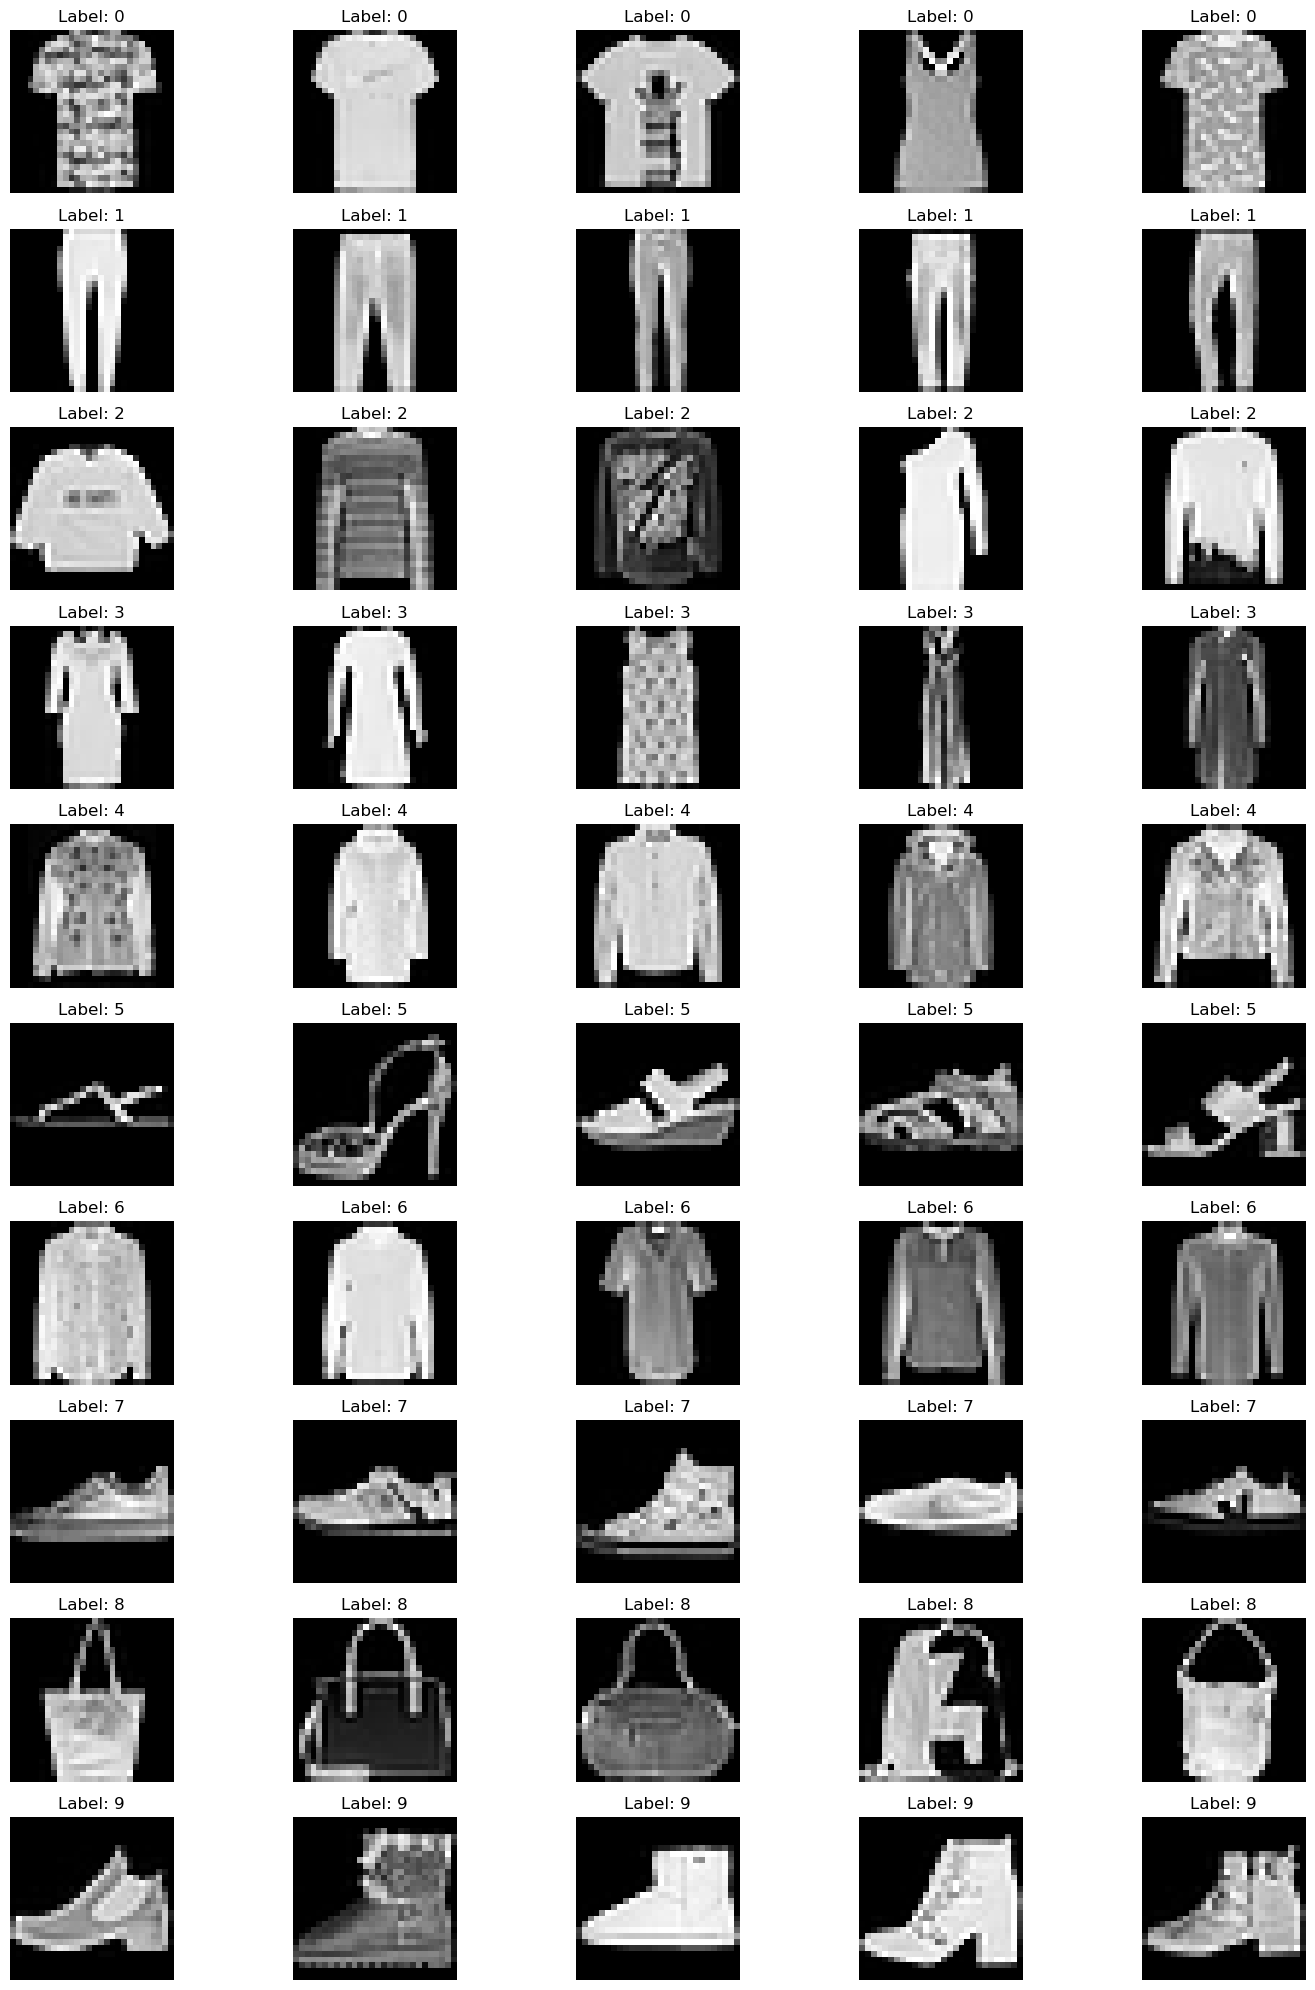

In [3]:
train_path = '../../data/interim/4/fashion_mnist/fashion-mnist_train_split.csv'
val_path = '../../data/interim/4/fashion_mnist/fashion-mnist_val_split.csv'
test_path = '../../data/interim/4/fashion_mnist/fashion-mnist_test.csv'

# Load the CSV files
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Get the number of data points in each file
train_size = train_data.shape[0]
val_size = val_data.shape[0]
test_size = test_data.shape[0]

print(f"Number of data points in the training file: {train_size}")
print(f"Number of data points in the val file: {val_size}")
print(f"Number of data points in the test file: {test_size}")


# Function to display five images per unique class label
def display_five_images_per_class(data):
    unique_labels = sorted(data.iloc[:, 0].unique())  # Get sorted unique class labels
    num_images = 5  # Number of images per label
    plt.figure(figsize=(15, len(unique_labels) * 2))

    for i, label in enumerate(unique_labels):
        # Filter data for the specific label and select the first five images of each class
        class_data = data[data.iloc[:, 0] == label].head(num_images)
        
        for j in range(num_images):
            image = class_data.iloc[j, 1:].values.reshape(28, 28)

            # Display the image
            plt.subplot(len(unique_labels), num_images, i * num_images + j + 1)
            plt.imshow(image, cmap='gray')
            plt.title(f"Label: {label}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display five images per unique label from the training set
display_five_images_per_class(train_data)


Following are the clothe types represented by each class:

0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot

## 4.2.2
## 4.2.3

Epoch [1/10], Train Loss: 0.0262, Val Loss: 0.0146
Epoch [2/10], Train Loss: 0.0126, Val Loss: 0.0112
Epoch [3/10], Train Loss: 0.0105, Val Loss: 0.0100
Epoch [4/10], Train Loss: 0.0094, Val Loss: 0.0094
Epoch [5/10], Train Loss: 0.0088, Val Loss: 0.0087
Epoch [6/10], Train Loss: 0.0083, Val Loss: 0.0083
Epoch [7/10], Train Loss: 0.0080, Val Loss: 0.0081
Epoch [8/10], Train Loss: 0.0078, Val Loss: 0.0078
Epoch [9/10], Train Loss: 0.0076, Val Loss: 0.0077
Epoch [10/10], Train Loss: 0.0074, Val Loss: 0.0075


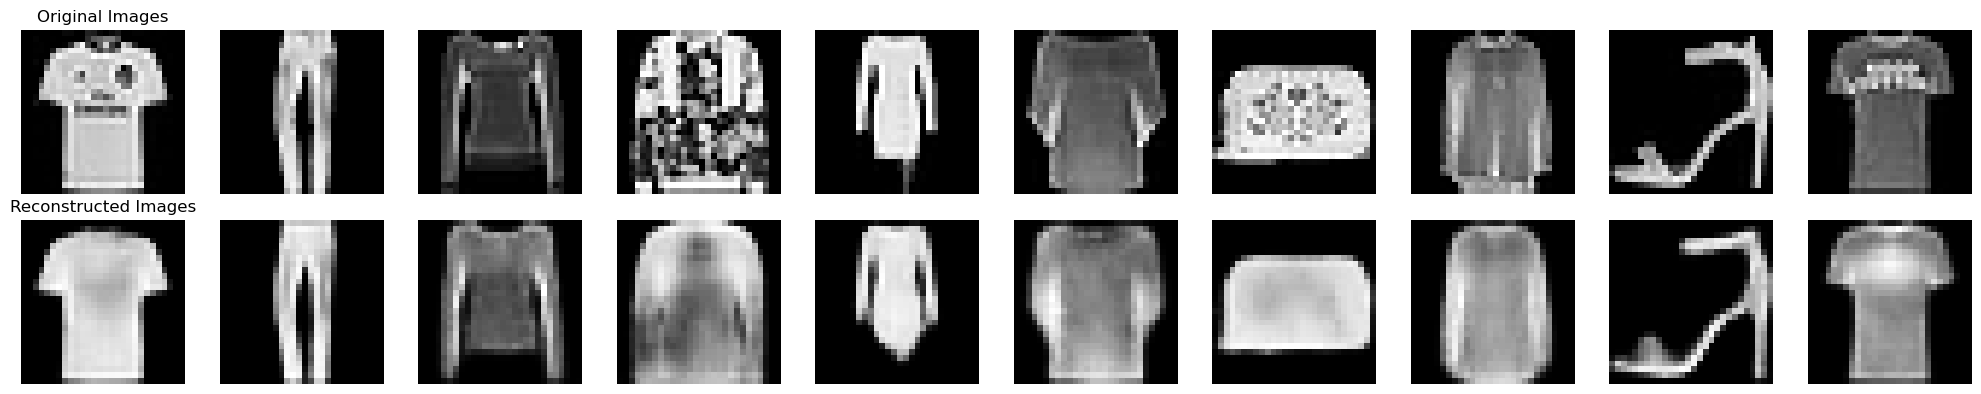

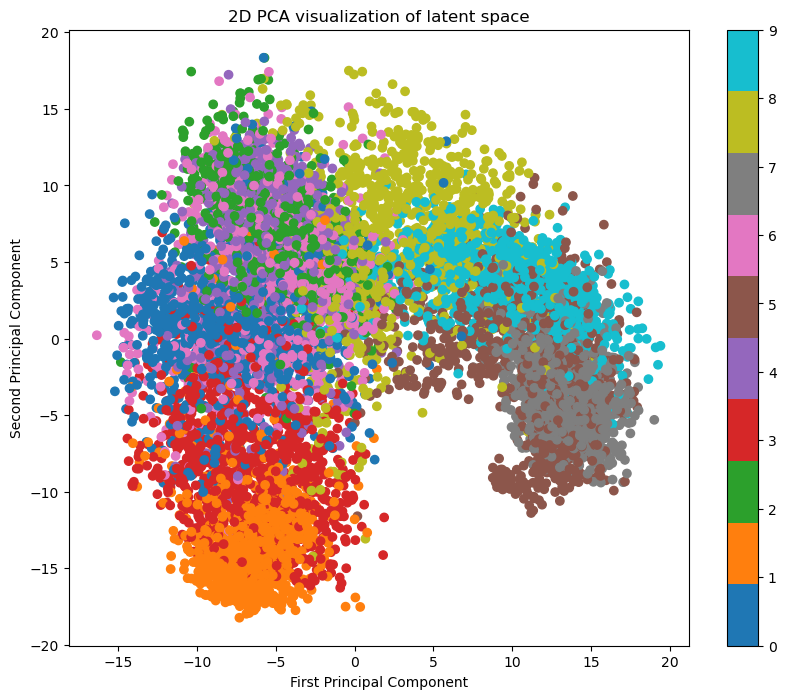

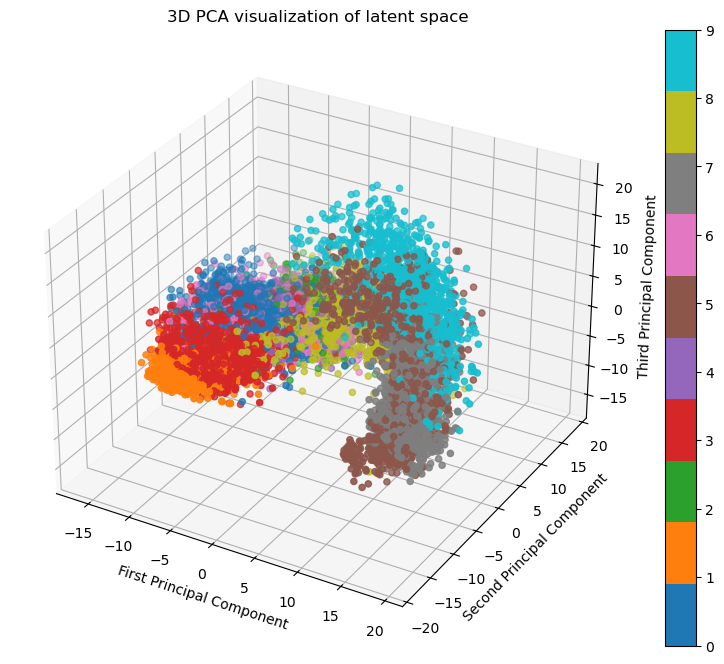

In [31]:
from sklearn.decomposition import PCA

class CnnAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(CnnAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

def prepare_data(train_data, val_data, test_data):
    # Separate features and labels
    X_train = torch.FloatTensor(train_data.iloc[:, 1:].values).reshape(-1, 1, 28, 28) / 255.0
    y_train = torch.LongTensor(train_data.iloc[:, 0].values)
    
    X_val = torch.FloatTensor(val_data.iloc[:, 1:].values).reshape(-1, 1, 28, 28) / 255.0
    y_val = torch.LongTensor(val_data.iloc[:, 0].values)
    
    X_test = torch.FloatTensor(test_data.iloc[:, 1:].values).reshape(-1, 1, 28, 28) / 255.0
    y_test = torch.LongTensor(test_data.iloc[:, 0].values)
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    return train_loader, val_loader, test_loader

def train_autoencoder(model, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                output = model(data)
                loss = criterion(output, data)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
        # if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    
    return train_losses, val_losses

def visualize_reconstructions(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    # Get 10 random test images
    data_iter = iter(test_loader)
    images, _ = next(data_iter)
    images = images[:10].to(device)
    
    with torch.no_grad():
        reconstructed = model(images)
    
    # Plot original and reconstructed images
    plt.figure(figsize=(20, 4))
    for i in range(10):
        # Original
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original Images')
        
        # Reconstructed
        plt.subplot(2, 10, i + 11)
        plt.imshow(reconstructed[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed Images')
    
    plt.tight_layout()
    plt.show()

def visualize_latent_space(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    # Get encoded representations
    encoded_data = []
    labels = []
    
    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            encoded = model.encode(data)
            encoded_data.append(encoded.cpu().numpy())
            labels.extend(label.numpy())
    
    encoded_data = np.concatenate(encoded_data, axis=0)
    labels = np.array(labels)
    
    # Apply PCA
    pca = PCA(n_components=3)
    encoded_pca = pca.fit_transform(encoded_data)
    
    # 2D Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(encoded_pca[:, 0], encoded_pca[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title('2D PCA visualization of latent space')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.savefig("figures/CNNAutoencoder_2D.png")
    plt.show()
    
    # 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(encoded_pca[:, 0], encoded_pca[:, 1], encoded_pca[:, 2], 
                        c=labels, cmap='tab10')
    plt.colorbar(scatter)
    ax.set_title('3D PCA visualization of latent space')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_zlabel('Third Principal Component')
    plt.savefig("figures/CNNAutoencoder_3D.png")
    plt.show()

# Create and train the model
model = CnnAutoencoder()
train_loader, val_loader, test_loader = prepare_data(train_data, val_data, test_data)

# Train the model
train_losses, val_losses = train_autoencoder(model, train_loader, val_loader)

# Visualize reconstructions
visualize_reconstructions(model, test_loader)

# Visualize latent space
visualize_latent_space(model, test_loader)

## Observations based on above 2D, 3D latent space plots:

Based on observations by looking images given in the dataset, labels 0, 2, 4 and 6 are very similar to 
each other(all are clothes which are used for upper half of the body). 
Also laebels 5, 7 and 9 are similar to eachother(all are footwears).  
All these observations clearly match with the 2D latent space plot. In that plot data points with labels 0, 2, 4, 6 are
well mixed and very close to eachother. Same for data points with labels 5 and 7. 9 is quite separable. 
In case of 3D latent space plot also this follows to some extent. Data points with lables 2, 4, and 6 are very much mized i.e very close.
Here label 0 is a bit separable from them. 
Same follows for data points having labels 5 and 7 they are mized and close to eachother. But here also label 9 is very much separable. 
Hence it can be concluded that the 2D, 3D latent space representations show clusters as expected.      
This indicates that CNN Autoencoder is able to encode the data effectively. 

## 4.2.4

Training Configuration 1 (Base)
Epoch [1/10], Train Loss: 0.0280, Val Loss: 0.0143
Epoch [2/10], Train Loss: 0.0124, Val Loss: 0.0112
Epoch [3/10], Train Loss: 0.0104, Val Loss: 0.0097
Epoch [4/10], Train Loss: 0.0093, Val Loss: 0.0090
Epoch [5/10], Train Loss: 0.0087, Val Loss: 0.0087
Epoch [6/10], Train Loss: 0.0083, Val Loss: 0.0082
Epoch [7/10], Train Loss: 0.0080, Val Loss: 0.0079
Epoch [8/10], Train Loss: 0.0077, Val Loss: 0.0078
Epoch [9/10], Train Loss: 0.0075, Val Loss: 0.0077
Epoch [10/10], Train Loss: 0.0074, Val Loss: 0.0075

Training Configuration 2 (More Filters)
Epoch [1/10], Train Loss: 0.0266, Val Loss: 0.0143
Epoch [2/10], Train Loss: 0.0123, Val Loss: 0.0110
Epoch [3/10], Train Loss: 0.0103, Val Loss: 0.0098
Epoch [4/10], Train Loss: 0.0092, Val Loss: 0.0089
Epoch [5/10], Train Loss: 0.0086, Val Loss: 0.0085
Epoch [6/10], Train Loss: 0.0081, Val Loss: 0.0081
Epoch [7/10], Train Loss: 0.0078, Val Loss: 0.0078
Epoch [8/10], Train Loss: 0.0075, Val Loss: 0.0076
Epoch [9

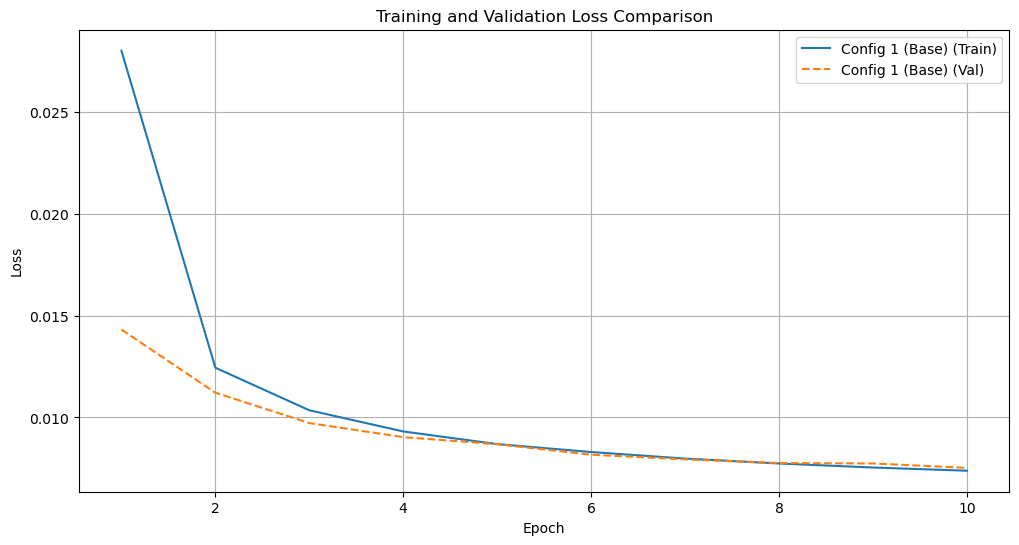

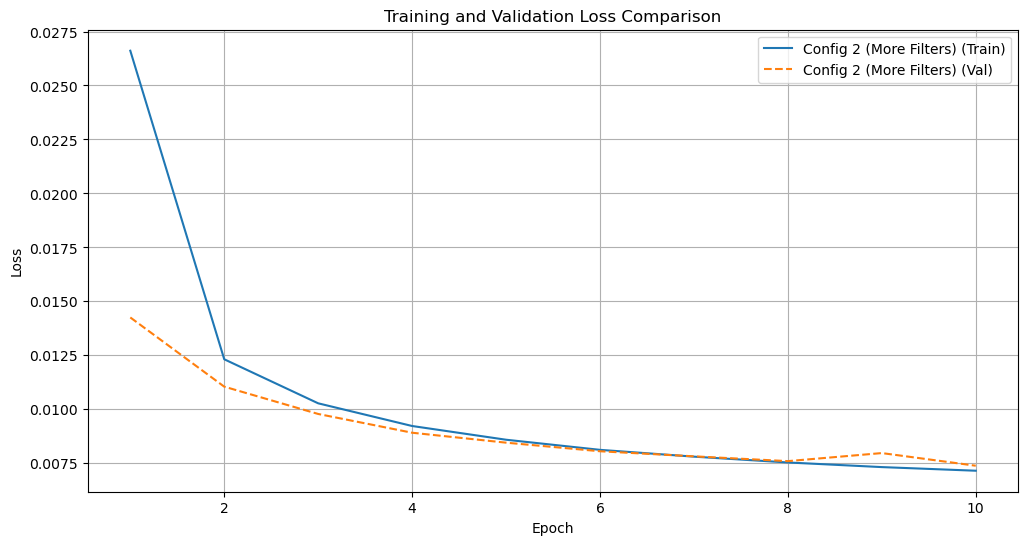

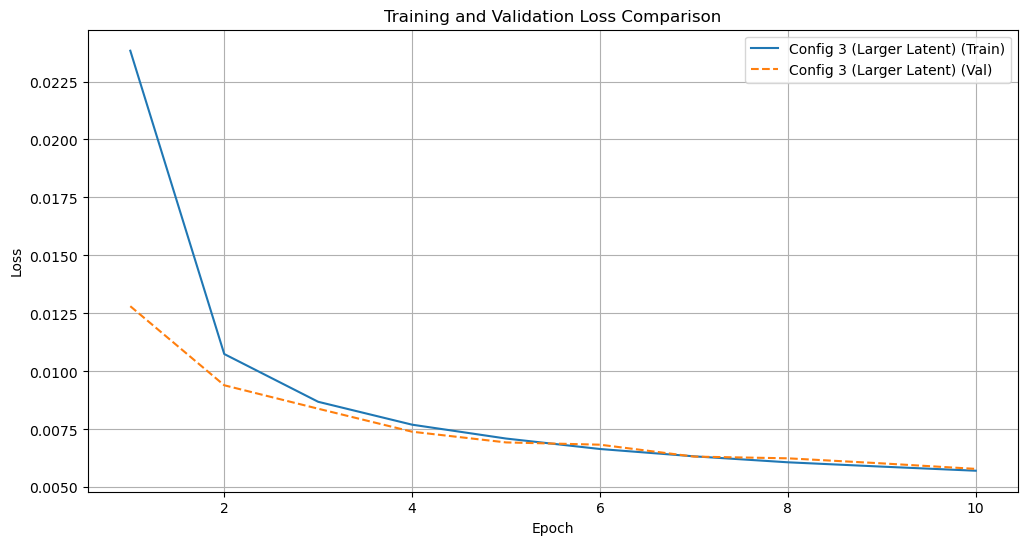

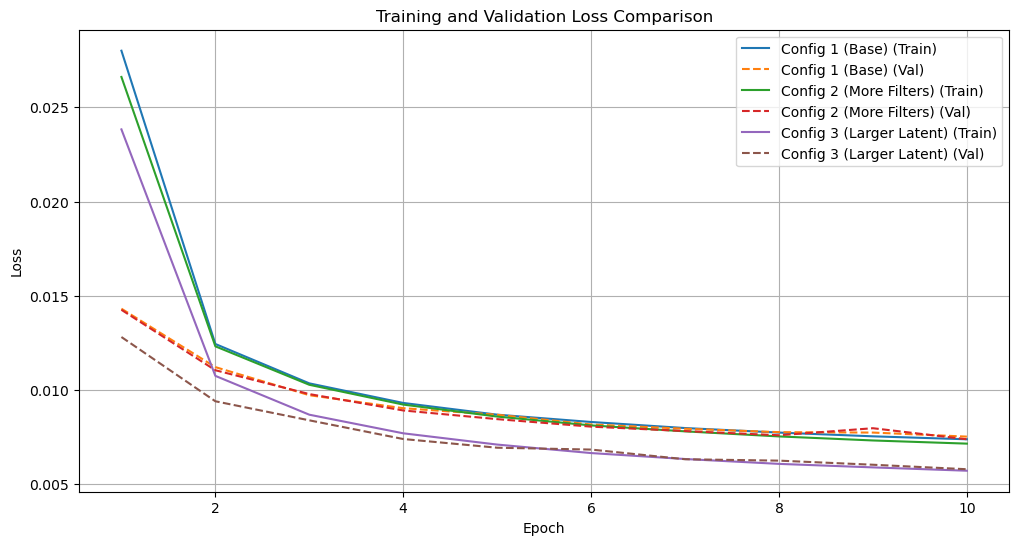


Best performing model: Config 3 with validation loss: 0.0058


In [34]:
# Base Autoencoder with default parameters (Configuration 1)
class CnnAutoencoder1(nn.Module):
    def __init__(self, latent_dim=32):
        super(CnnAutoencoder1, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

# Autoencoder with different filter sizes (Configuration 2)
class CnnAutoencoder2(nn.Module):
    def __init__(self, latent_dim=32):
        super(CnnAutoencoder2, self).__init__()
        
        # Encoder with more filters
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # More filters
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # More filters
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # More filters
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, latent_dim)
        )
        
        # Decoder with more filters
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

# Autoencoder with different latent dimension (Configuration 3)
class CnnAutoencoder3(nn.Module):
    def __init__(self, latent_dim=64):  # Larger latent dimension
        super(CnnAutoencoder3, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)  # Different latent dimension
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),  # Different latent dimension
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                output = model(data)
                loss = criterion(output, data)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
        # if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, 'f'Val Loss: {val_losses[-1]:.4f}')
    
    return train_losses, val_losses

def plot_loss_comparison(results):
    
    for config_name, (train_loss, val_loss) in results.items():
        plt.figure(figsize=(12, 6))
        epochs = range(1, len(train_loss) + 1)
        plt.plot(epochs, train_loss, label=f'{config_name} (Train)')
        plt.plot(epochs, val_loss, label=f'{config_name} (Val)', linestyle='--')
    
        plt.title('Training and Validation Loss Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    plt.figure(figsize=(12, 6))
    for config_name, (train_loss, val_loss) in results.items():
        epochs = range(1, len(train_loss) + 1)
        plt.plot(epochs, train_loss, label=f'{config_name} (Train)')
        plt.plot(epochs, val_loss, label=f'{config_name} (Val)', linestyle='--')
    
    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()







# Initialize models with different configurations
model1 = CnnAutoencoder1()  # Base configuration (lr=0.001)
model2 = CnnAutoencoder2()  # More filters configuration (lr=0.0005)
model3 = CnnAutoencoder3()  # Larger latent space configuration (lr=0.002)

# Initialize optimizers with different learning rates
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.0005)
optimizer3 = optim.Adam(model3.parameters(), lr=0.002)

results = {}

# Train each model configuration
print("Training Configuration 1 (Base)")
train_loss1, val_loss1 = train_model(model1, train_loader, val_loader, optimizer1)
results['Config 1 (Base)'] = (train_loss1, val_loss1)

print("\nTraining Configuration 2 (More Filters)")
train_loss2, val_loss2 = train_model(model2, train_loader, val_loader, optimizer2)
results['Config 2 (More Filters)'] = (train_loss2, val_loss2)

print("\nTraining Configuration 3 (Larger Latent)")
train_loss3, val_loss3 = train_model(model3, train_loader, val_loader, optimizer3)
results['Config 3 (Larger Latent)'] = (train_loss3, val_loss3)

# Plot comparison
plot_loss_comparison(results)

# Find best performing model
final_val_losses = {
    'Config 1': min(val_loss1),
    'Config 2': min(val_loss2),
    'Config 3': min(val_loss3)
}
best_config = min(final_val_losses.items(), key=lambda x: x[1])
print(f"\nBest performing model: {best_config[0]} with validation loss: {best_config[1]:.4f}")


# 4.3 MLP Autoencoder 

In [4]:
train_path = '../../data/interim/4/fashion_mnist/fashion-mnist_train_split.csv'
val_path = '../../data/interim/4/fashion_mnist/fashion-mnist_val_split.csv'
test_path = '../../data/interim/4/fashion_mnist/fashion-mnist_test.csv'

# Load the dataset
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# Extract features and labels
X_train = train_df.iloc[:, 1:].values / 255.0  # Normalize to [0, 1]
X_val = val_df.iloc[:, 1:].values / 255.0
X_test = test_df.iloc[:, 1:].values / 255.0


layer_sizes:  [784, 128, 64, 64]
layer_sizes:  [64, 64, 128, 784]
Epoch 1/4, Loss: 0.1811, Val Loss: 0.0885
Epoch 2/4, Loss: 0.0881, Val Loss: 0.0885
Epoch 3/4, Loss: 0.0881, Val Loss: 0.0885
Epoch 4/4, Loss: 0.0881, Val Loss: 0.0885


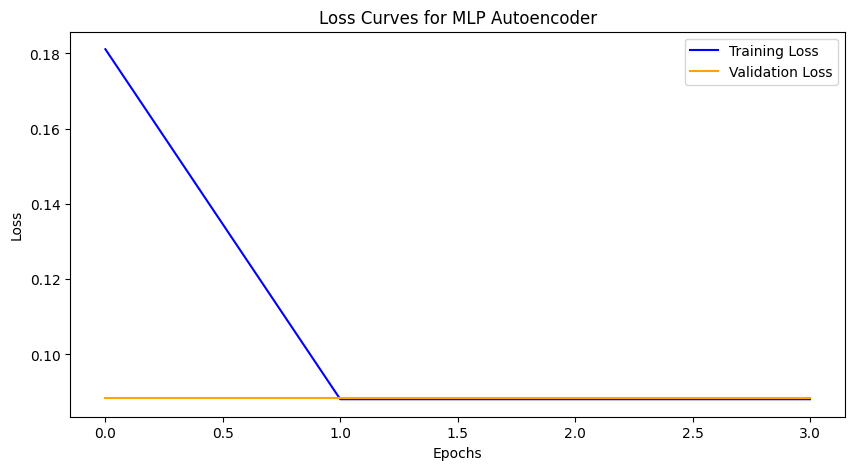

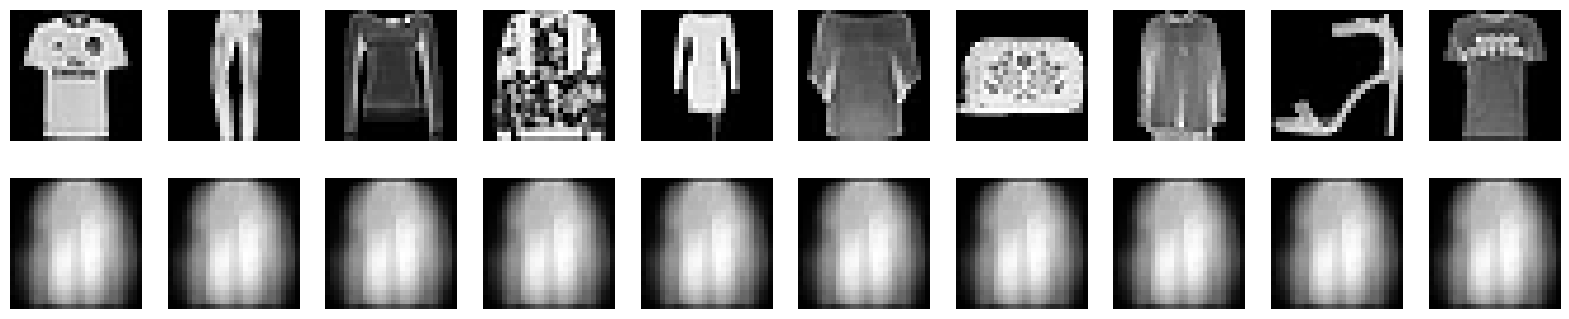

In [5]:

class AutoEncoder:
    def __init__(self, input_size, latent_size, hidden_layers, learning_rate=0.01, activation='relu', optimizer='sgd', epochs=4, early_stopping=False, patience=15):
        """
        Initializes the autoencoder model by setting up the encoder and decoder using the MLP_Regression class.
        """
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.patience = patience

        self.loss_history = []  # To track training loss
        self.val_loss_history = []  # To track validation loss
        
        # Define the encoder: Compresses input to latent space
        self.encoder = MLP_Regression(
            input_size=input_size,
            hidden_layers=hidden_layers,
            output_size=latent_size,
            learning_rate=learning_rate,
            activation=activation,
            optimizer=optimizer,
            epochs=epochs,
            task='regression',
            early_stopping=True,
            patience=patience
        )
        
        # Define the decoder: Reconstructs original input from latent space
        self.decoder = MLP_Regression(
            input_size=latent_size,
            hidden_layers=hidden_layers[::-1],  # Reversed hidden layers for symmetry
            output_size=input_size,
            learning_rate=learning_rate,
            activation=activation,
            optimizer=optimizer,
            epochs=epochs,
            task='regression',
            early_stopping=early_stopping,
            patience=patience
        )


    def fit(self, X_train, X_val=None):
        n_samples = X_train.shape[0]
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(self.epochs):
            # Pass the input through encoder and decoder
            latent_rep = self.encoder.predict(X_train)
            reconstructed_X = self.decoder.predict(latent_rep)
            
            # Calculate loss (reconstruction error)
            loss = np.mean((X_train - reconstructed_X) ** 2)
            self.loss_history.append(loss)  # Save the training loss
            
            # Update encoder and decoder with backpropagation
            self.encoder.fit(X_train, latent_rep)
            self.decoder.fit(latent_rep, X_train)

            if X_val is not None:
                val_reconstruction = self.decoder.predict(self.encoder.predict(X_val))
                val_loss = np.mean((X_val - val_reconstruction) ** 2)
                self.val_loss_history.append(val_loss)  # Save the validation loss
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if self.early_stopping and patience_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
            
            print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}" if X_val is not None else f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}")

    def get_latent(self, X):
        """
        Returns the latent space representation (compressed data) of the input X.
        """
        latent_rep = self.encoder.predict(X)
        return latent_rep



# Define autoencoder parameters
input_size = 784  # 28x28 images flattened
latent_size = 64  # Size of the latent space
hidden_layers = [128, 64]  # Hidden layers in the encoder

# Instantiate the autoencoder
autoencoder = AutoEncoder(input_size=input_size, latent_size=latent_size, hidden_layers=hidden_layers, epochs=4, early_stopping=True)

# # Fit the autoencoder
# autoencoder.fit(X_train, X_val)

# # Plot the loss curves
# plt.plot(autoencoder.loss_history, label='Training Loss')
# if X_val is not None:
#     plt.plot(val_loss_history, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss Curves for MLP Autoencoder')
# plt.legend()
# plt.show()


# # Predict the reconstructed images
# reconstructed_images = autoencoder.decoder.predict(autoencoder.get_latent(X_test))

# Plot original and reconstructed images
def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(2 * n, 4))
    for i in range(n):
        # Original images
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        
        # Reconstructed images
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# # Visualize original and reconstructed images
# plot_images(X_test, reconstructed_images)

# Fit the autoencoder
autoencoder.fit(X_train, X_val)

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(autoencoder.loss_history, label='Training Loss', color='blue')
if autoencoder.val_loss_history:  # Check if validation loss history is not empty
    plt.plot(autoencoder.val_loss_history, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves for MLP Autoencoder')
plt.legend()
plt.show()

# Predict the reconstructed images
reconstructed_images = autoencoder.decoder.predict(autoencoder.get_latent(X_test))

# Plot original and reconstructed images
plot_images(X_test, reconstructed_images)


### Loss based comparison between CNN autoencoder and MLP autoencoder:

Loss is decreasing with epochs in CNN autoencoder. But for MLP autoencoder it has become constant after 2nd epoch. Also the final losses in case of MLP autoencoder are aruond 10 times greater than that of CNN autoencoder. I think the main reason for this is in case of MLP autoencoder hyprparameter tuning is not done also it is prone to bad initialization of weights. Because of these reasons the loss is not deceasing in case of MLP autoencoder and it is higher than that of CNN autoencoder.


### Comparison based on reconstruction of images:

Reconstructed images of CNN autoencoder clearly match with the original images unlike MLP autoencoder. In case of MLP autoencoder as stated above there is no loss update and hence reconstructed images are not matching with the otiginal images.

Hence from both criterias of comparison we can coclude that CNN autoencoder is better than MLP autoencoder. 

# 4.4

## 4.4.1

## 4.4.2

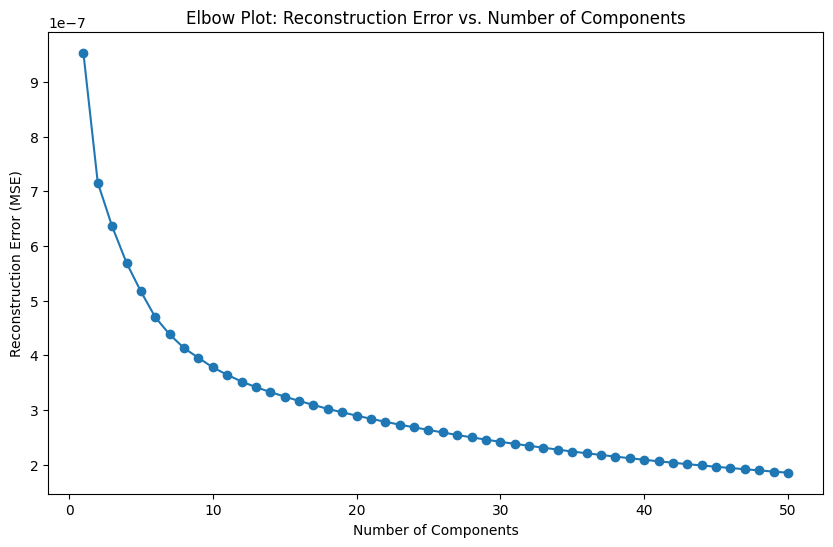

In [18]:
class PcaAutoencoder:
    def __init__(self, n_components):
        """
        Initialize the PCA autoencoder with the desired number of components.
        :param n_components: The number of principal components for dimensionality reduction.
        """
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components)

    def fit(self, X):
        """
        Fit the PCA model on the input data to learn principal components.
        :param X: Input data of shape (n_samples, n_features)
        """
        self.pca.fit(X)

    def encode(self, X):
        """
        Reduce the dimensionality of the input data using learned PCA components.
        :param X: Input data of shape (n_samples, n_features)
        :return: Encoded data of shape (n_samples, n_components)
        """
        return self.pca.transform(X)

    def forward(self, X):
        """
        Reconstruct the input data from its encoded (compressed) representation.
        :param X: Input data of shape (n_samples, n_features)
        :return: Reconstructed data of shape (n_samples, n_features)
        """
        X_encoded = self.encode(X)
        return self.pca.inverse_transform(X_encoded)


def estimate_optimal_components(train_data, val_data, max_components=50):
    reconstruction_errors = []

    for n_components in range(1, max_components + 1):
        # Initialize and train the PCA autoencoder
        pca_autoencoder = PcaAutoencoder(n_components)
        pca_autoencoder.fit(train_data)
        
        # Reconstruct validation data
        reconstructed_val_data = pca_autoencoder.forward(val_data)
        
        # Compute MSE reconstruction error
        mse_error = metrics1.calculate_mse(val_data, reconstructed_val_data)
        reconstruction_errors.append(mse_error)

    # Plot the reconstruction error for each number of components
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components + 1), reconstruction_errors, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.title('Elbow Plot: Reconstruction Error vs. Number of Components')
    plt.show()

    # Determine the optimal number of components (k_optimal)
    # Generally, the elbow point can be identified visually.
    # k_optimal = reconstruction_errors.index(min(reconstruction_errors)) + 1
    # print(f"Optimal number of components (k_optimal): {k_optimal}")

    # return k_optimal



def visualize_reconstructions(test_data, k_optimal):
    # Initialize PCA autoencoder with k_optimal components
    pca_autoencoder = PcaAutoencoder(k_optimal)
    pca_autoencoder.fit(test_data)
    
    # Get reconstructed images
    reconstructed_data = pca_autoencoder.forward(test_data)
    
    # Plot original and reconstructed images
    num_images = 10
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original images
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(test_data[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")
        
        # Reconstructed images
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_data[i].reshape(28, 28), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()






# Load the dataset
train_path = '../../data/interim/4/fashion_mnist/fashion-mnist_train_split.csv'
val_path = '../../data/interim/4/fashion_mnist/fashion-mnist_val_split.csv'
test_path = '../../data/interim/4/fashion_mnist/fashion-mnist_test.csv'

# Assuming data is stored as CSV and can be loaded into DataFrames
# Load the dataset without the label column
train_data = pd.read_csv(train_path).values[:, 1:] / 255.0  # Only pixel columns, normalized
val_data = pd.read_csv(val_path).values[:, 1:] / 255.0
test_data = pd.read_csv(test_path).values[:, 1:] / 255.0


# Scale the data (e.g., normalization between 0 and 1 if not already scaled)
train_data = train_data / 255.0
val_data = val_data / 255.0
test_data = test_data / 255.0

# Estimate optimal number of components
max_components = 50  # Max number of components to test, you can adjust as needed
estimate_optimal_components(train_data, val_data, max_components=max_components)

Optimal number of components: 12


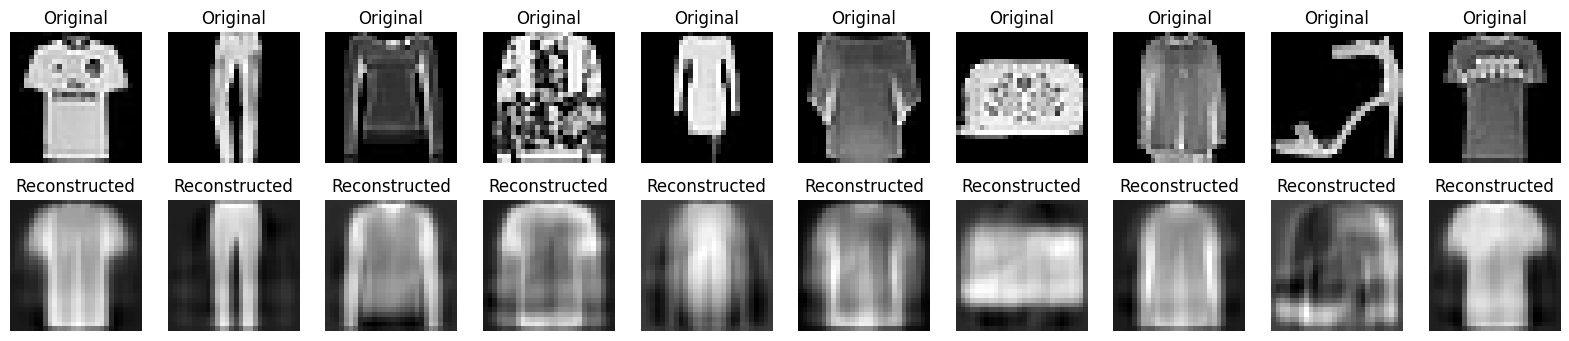

In [ ]:
k_optimal = 12
print(f"Optimal number of components: {k_optimal}")

# Visualize original vs reconstructed images with k_optimal components
visualize_reconstructions(test_data, k_optimal)

### Compare results with those obtained using the CNN and MLP autoencoders.

PCA autoencoder has loss lesser than both CNN and MLP autoencoders. The reconstructed images are very much similar to the original. As we increase the number of components the reconstructed images are more closer to the original once. The results of PCA autoencoder are far better than MLP autoencoder as it gives better reconstruted images. As compared to CNN autoencoder, I think CNN autoencoder is better as it is able to produce better reconstructed images than PCA autoencoder. 

# 4.5 KNN

In [3]:
k_optimal = 12
# Autoencoder with different latent dimension (Configuration 3)
class CnnAutoencoder3(nn.Module):
    def __init__(self, latent_dim=64):  # Larger latent dimension
        super(CnnAutoencoder3, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)  # Different latent dimension
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),  # Different latent dimension
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                output = model(data)
                loss = criterion(output, data)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        
        # if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, 'f'Val Loss: {val_losses[-1]:.4f}')
    
    return train_losses, val_losses



def prepare_data(train_data, val_data, test_data):
    # Separate features and labels
    X_train = torch.FloatTensor(train_data.iloc[:, 1:].values).reshape(-1, 1, 28, 28) / 255.0
    y_train = torch.LongTensor(train_data.iloc[:, 0].values)
    
    X_val = torch.FloatTensor(val_data.iloc[:, 1:].values).reshape(-1, 1, 28, 28) / 255.0
    y_val = torch.LongTensor(val_data.iloc[:, 0].values)
    
    X_test = torch.FloatTensor(test_data.iloc[:, 1:].values).reshape(-1, 1, 28, 28) / 255.0
    y_test = torch.LongTensor(test_data.iloc[:, 0].values)
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    return train_loader, val_loader, test_loader

train_path = '../../data/interim/4/fashion_mnist/fashion-mnist_train_split.csv'
val_path = '../../data/interim/4/fashion_mnist/fashion-mnist_val_split.csv'
test_path = '../../data/interim/4/fashion_mnist/fashion-mnist_test.csv'

# Load the CSV files
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)


train_loader, val_loader, test_loader = prepare_data(train_data, val_data, test_data)



In [34]:
model3 = CnnAutoencoder3()
optimizer3 = optim.Adam(model3.parameters(), lr=0.002)
_, _ = train_model(model3, train_loader, val_loader, optimizer3, num_epochs=2)


Epoch [1/2], Train Loss: 0.0203, Val Loss: 0.0117
Epoch [2/2], Train Loss: 0.0098, Val Loss: 0.0090


k = 1 and distance metric = manhattan
Validation Accuracy for k=1, distance_metric=manhattan: 0.8284
Validation Macro Precision: 0.8287
Validation Macro Recall: 0.8280
Validation Macro F1 Score: 0.8283
Validation Micro Precision: 0.8284
Validation Micro Recall: 0.8284
Validation Micro F1 Score: 0.8284

Test Accuracy for k=1, distance_metric=manhattan: 0.7945
Train Accuracy for k=1, distance_metric=manhattan: 1.0000


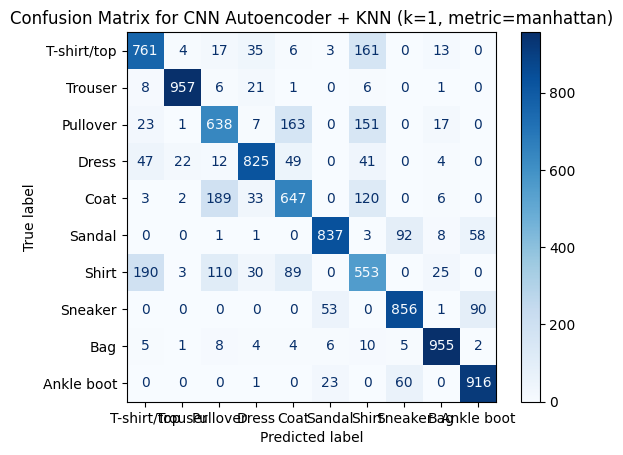

In [ ]:
from sklearn.decomposition import PCA
# Load and Encode Data using CNN autoencoder (model3)
def get_encoded_data(model, data_loader, device, pca_components):
    model.eval()
    encoded_data = []
    labels = []
    
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            encoded = model.encode(data)  # Use model3's encoder
            encoded_data.append(encoded.cpu().numpy())
            labels.extend(label.numpy())
    
    encoded_data = np.concatenate(encoded_data, axis=0)
    labels = np.array(labels)
    
    # Apply PCA for dimensionality reduction to koptimal dimensions
    pca = PCA(n_components=pca_components)
    encoded_data_reduced = pca.fit_transform(encoded_data)
    
    return encoded_data_reduced, labels

# Set parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_components = k_optimal # Replace with the value of koptimal

# Obtain encoded and reduced data for train, validation, and test sets
X_train, y_train = get_encoded_data(model3, train_loader, device, num_components)
X_val, y_val = get_encoded_data(model3, val_loader, device, num_components)
X_test, y_test = get_encoded_data(model3, test_loader, device, num_components)

# Initialize KNN with specified parameters
k = 1
distance_metric = 'manhattan'
knn_model = KNN(k=k, distance_metric=distance_metric)

# Perform KNN classification on validation data
print(f"k = {k} and distance metric = {distance_metric}")

# Predict on validation set
y_val_pred = knn_model.predict(X_train, y_train, X_val)

# Evaluate validation accuracy
val_metrics = Metrics(y_val, y_val_pred)  # Assuming metrics is imported from performance_measures
val_accuracy = val_metrics.accuracy()
print(f"Validation Accuracy for k={k}, distance_metric={distance_metric}: {val_accuracy:.4f}")

# Calculate detailed metrics
macro_precision = val_metrics.macro_precision()
macro_recall = val_metrics.macro_recall()
macro_f1 = val_metrics.macro_f1()
micro_precision = val_metrics.micro_precision()
micro_recall = val_metrics.micro_recall()
micro_f1 = val_metrics.micro_f1()

# Print evaluation results
print(f"Validation Macro Precision: {macro_precision:.4f}")
print(f"Validation Macro Recall: {macro_recall:.4f}")
print(f"Validation Macro F1 Score: {macro_f1:.4f}")
print(f"Validation Micro Precision: {micro_precision:.4f}")
print(f"Validation Micro Recall: {micro_recall:.4f}")
print(f"Validation Micro F1 Score: {micro_f1:.4f}")

# Testing on the test set
y_test_pred = knn_model.predict(X_train, y_train, X_test)

# Calculate test accuracy
test_metrics = Metrics(y_test, y_test_pred)
test_accuracy = test_metrics.accuracy()
print(f"\nTest Accuracy for k={k}, distance_metric={distance_metric}: {test_accuracy:.4f}")

# Testing on the train set
y_train_pred = knn_model.predict(X_train, y_train, X_train)

# Calculate train accuracy
train_metrics = Metrics(y_train, y_train_pred)
train_accuracy = train_metrics.accuracy()
print(f"Train Accuracy for k={k}, distance_metric={distance_metric}: {train_accuracy:.4f}")

# Generate and plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]).plot(cmap='Blues')
plt.title(f'Confusion Matrix for CNN Autoencoder + KNN (k={k}, metric={distance_metric})')
plt.show()


In [4]:

class AutoEncoder:
    def __init__(self, input_size, latent_size, hidden_layers, learning_rate=0.01, activation='relu', optimizer='sgd', epochs=4, early_stopping=False, patience=15):
        """
        Initializes the autoencoder model by setting up the encoder and decoder using the MLP_Regression class.
        """
        self.input_size = input_size
        self.latent_size = latent_size
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.patience = patience

        self.loss_history = []  # To track training loss
        self.val_loss_history = []  # To track validation loss
        
        # Define the encoder: Compresses input to latent space
        self.encoder = MLP_Regression(
            input_size=input_size,
            hidden_layers=hidden_layers,
            output_size=latent_size,
            learning_rate=learning_rate,
            activation=activation,
            optimizer=optimizer,
            epochs=epochs,
            task='regression',
            early_stopping=True,
            patience=patience
        )
        
        # Define the decoder: Reconstructs original input from latent space
        self.decoder = MLP_Regression(
            input_size=latent_size,
            hidden_layers=hidden_layers[::-1],  # Reversed hidden layers for symmetry
            output_size=input_size,
            learning_rate=learning_rate,
            activation=activation,
            optimizer=optimizer,
            epochs=epochs,
            task='regression',
            early_stopping=early_stopping,
            patience=patience
        )


    def fit(self, X_train, X_val=None):
        n_samples = X_train.shape[0]
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(self.epochs):
            # Pass the input through encoder and decoder
            latent_rep = self.encoder.predict(X_train)
            reconstructed_X = self.decoder.predict(latent_rep)
            
            # Calculate loss (reconstruction error)
            loss = np.mean((X_train - reconstructed_X) ** 2)
            self.loss_history.append(loss)  # Save the training loss
            
            # Update encoder and decoder with backpropagation
            self.encoder.fit(X_train, latent_rep)
            self.decoder.fit(latent_rep, X_train)

            if X_val is not None:
                val_reconstruction = self.decoder.predict(self.encoder.predict(X_val))
                val_loss = np.mean((X_val - val_reconstruction) ** 2)
                self.val_loss_history.append(val_loss)  # Save the validation loss
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if self.early_stopping and patience_counter >= self.patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
            
            print(f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}" if X_val is not None else f"Epoch {epoch + 1}/{self.epochs}, Loss: {loss:.4f}")

    def get_latent(self, X):
        """
        Returns the latent space representation (compressed data) of the input X.
        """
        latent_rep = self.encoder.predict(X)
        return latent_rep



In [9]:
# Load data
train_path = '../../data/interim/4/fashion_mnist/fashion-mnist_train_split.csv'
val_path = '../../data/interim/4/fashion_mnist/fashion-mnist_val_split.csv'
test_path = '../../data/interim/4/fashion_mnist/fashion-mnist_test.csv'

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# Extract features and labelsa
X_train = train_df.iloc[:, 1:].values / 255.0  # Normalize to [0, 1]
X_val = val_df.iloc[:, 1:].values / 255.0
X_test = test_df.iloc[:, 1:].values / 255.0
train_labels = train_df.iloc[:, 0].values
val_labels = val_df.iloc[:, 0].values
test_labels = test_df.iloc[:, 0].values

# Define autoencoder parameters
input_size = 784  # 28x28 images flattened
latent_size = k_optimal  # Size of the latent space
hidden_layers = [128, 64]  # Hidden layers in the encoder

# Instantiate and train the MLP Autoencoder
autoencoder = AutoEncoder(input_size=input_size, latent_size=latent_size, hidden_layers=hidden_layers, epochs=3, early_stopping=True)
autoencoder.fit(X_train, X_val)


layer_sizes:  [784, 128, 64, 12]
layer_sizes:  [12, 64, 128, 784]
Epoch 1/3, Loss: 0.1929, Val Loss: 0.0407
Epoch 2/3, Loss: 0.0398, Val Loss: 0.0402
Epoch 3/3, Loss: 0.0394, Val Loss: 0.0398


k = 1 and distance metric = manhattan
Validation Accuracy for k=1, distance_metric=manhattan: 0.5731
Validation Macro Precision: 0.5720
Validation Macro Recall: 0.5726
Validation Macro F1 Score: 0.5716
Validation Micro Precision: 0.5731
Validation Micro Recall: 0.5731
Validation Micro F1 Score: 0.5731

Test Accuracy for k=1, distance_metric=manhattan: 0.5767
Train Accuracy for k=1, distance_metric=manhattan: 1.0000


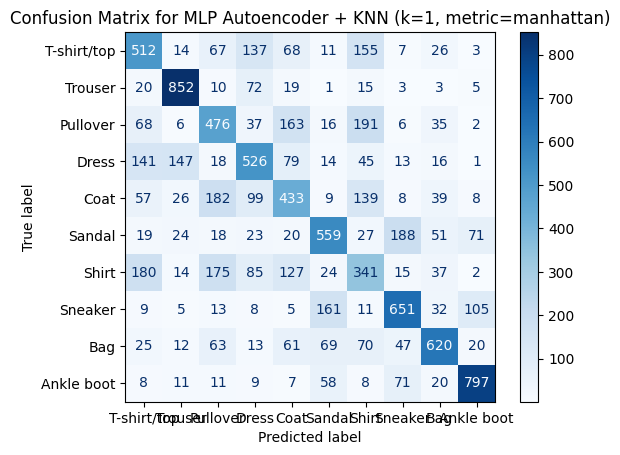

In [10]:

# Generate latent representations for train, validation, and test sets
X_train_reduced = autoencoder.get_latent(X_train)
X_val_reduced = autoencoder.get_latent(X_val)
X_test_reduced = autoencoder.get_latent(X_test)

# Initialize and apply KNN for classification on the reduced dataset
k = 1
distance_metric = 'manhattan'
knn_model = KNN(k=k, distance_metric=distance_metric)

# Validation Prediction
print(f"k = {k} and distance metric = {distance_metric}")

# Predict on validation set
y_val_pred = knn_model.predict(X_train_reduced, train_labels, X_val_reduced)

# Evaluate validation accuracy
val_metrics = Metrics(val_labels, y_val_pred)
val_accuracy = val_metrics.accuracy()
print(f"Validation Accuracy for k={k}, distance_metric={distance_metric}: {val_accuracy:.4f}")

# Calculate detailed metrics for validation
macro_precision = val_metrics.macro_precision()
macro_recall = val_metrics.macro_recall()
macro_f1 = val_metrics.macro_f1()
micro_precision = val_metrics.micro_precision()
micro_recall = val_metrics.micro_recall()
micro_f1 = val_metrics.micro_f1()

# Print evaluation results
print(f"Validation Macro Precision: {macro_precision:.4f}")
print(f"Validation Macro Recall: {macro_recall:.4f}")
print(f"Validation Macro F1 Score: {macro_f1:.4f}")
print(f"Validation Micro Precision: {micro_precision:.4f}")
print(f"Validation Micro Recall: {micro_recall:.4f}")
print(f"Validation Micro F1 Score: {micro_f1:.4f}")

# Test Prediction
y_test_pred = knn_model.predict(X_train_reduced, train_labels, X_test_reduced)

# Calculate test accuracy
test_metrics = Metrics(test_labels, y_test_pred)
test_accuracy = test_metrics.accuracy()
print(f"\nTest Accuracy for k={k}, distance_metric={distance_metric}: {test_accuracy:.4f}")

# Testing on the train set
y_train_pred = knn_model.predict(X_train_reduced, train_labels, X_train_reduced)

# Calculate train accuracy
train_metrics = Metrics(train_labels, y_train_pred)
train_accuracy = train_metrics.accuracy()
print(f"Train Accuracy for k={k}, distance_metric={distance_metric}: {train_accuracy:.4f}")
# Plot confusion matrix for test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]).plot(cmap='Blues')
plt.title(f'Confusion Matrix for MLP Autoencoder + KNN (k={k}, metric={distance_metric})')
plt.show()


k = 1 and distance metric = manhattan
Validation Accuracy for k=1, distance_metric=manhattan: 0.8009
Validation Macro Precision: 0.8003
Validation Macro Recall: 0.8004
Validation Macro F1 Score: 0.8002
Validation Micro Precision: 0.8009
Validation Micro Recall: 0.8009
Validation Micro F1 Score: 0.8009

Test Accuracy for k=1, distance_metric=manhattan: 0.7971
Train Accuracy for k=1, distance_metric=manhattan: 1.0000


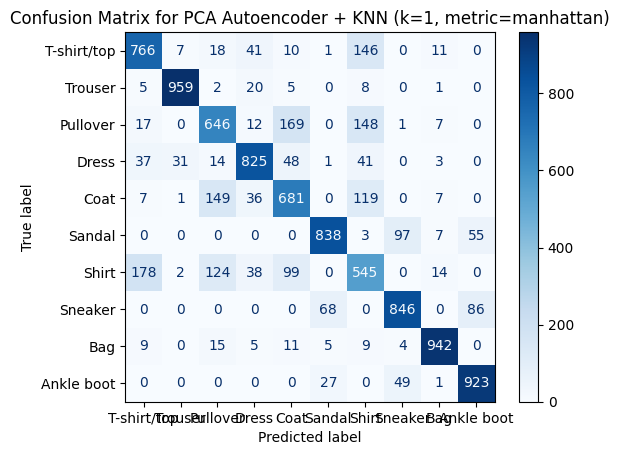

In [39]:
from models.pca.pca import PCA

# Define PCA Autoencoder
class PcaAutoencoder:
    def __init__(self, n_components):
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components)

    def fit(self, X):
        self.pca.fit(X)

    def encode(self, X):
        return self.pca.transform(X)

    def forward(self, X):
        X_encoded = self.encode(X)
        return self.pca.inverse_transform(X_encoded)

# Load data
train_path = '../../data/interim/4/fashion_mnist/fashion-mnist_train_split.csv'
val_path = '../../data/interim/4/fashion_mnist/fashion-mnist_val_split.csv'
test_path = '../../data/interim/4/fashion_mnist/fashion-mnist_test.csv'

# Load the dataset without the label column
train_data = pd.read_csv(train_path).values[:, 1:] / 255.0
val_data = pd.read_csv(val_path).values[:, 1:] / 255.0
test_data = pd.read_csv(test_path).values[:, 1:] / 255.0
train_labels = pd.read_csv(train_path).values[:, 0]
val_labels = pd.read_csv(val_path).values[:, 0]
test_labels = pd.read_csv(test_path).values[:, 0]


# Initialize PCA Autoencoder with k_optimal and fit on training data
pca_autoencoder = PcaAutoencoder(n_components=k_optimal)
pca_autoencoder.fit(train_data)

# Encode training, validation, and test data
X_train_reduced = pca_autoencoder.encode(train_data)
X_val_reduced = pca_autoencoder.encode(val_data)
X_test_reduced = pca_autoencoder.encode(test_data)





# Initialize and use KNN for classification on the reduced dataset
k = 1
distance_metric = 'manhattan'
knn_model = KNN(k=k, distance_metric=distance_metric)

# Validation Prediction
print(f"k = {k} and distance metric = {distance_metric}")

# Predict on validation set
y_val_pred = knn_model.predict(X_train_reduced, train_labels, X_val_reduced)

# Evaluate validation accuracy
val_metrics = Metrics(val_labels, y_val_pred)
val_accuracy = val_metrics.accuracy()
print(f"Validation Accuracy for k={k}, distance_metric={distance_metric}: {val_accuracy:.4f}")

# Calculate detailed metrics for validation
macro_precision = val_metrics.macro_precision()
macro_recall = val_metrics.macro_recall()
macro_f1 = val_metrics.macro_f1()
micro_precision = val_metrics.micro_precision()
micro_recall = val_metrics.micro_recall()
micro_f1 = val_metrics.micro_f1()

# Print evaluation results
print(f"Validation Macro Precision: {macro_precision:.4f}")
print(f"Validation Macro Recall: {macro_recall:.4f}")
print(f"Validation Macro F1 Score: {macro_f1:.4f}")
print(f"Validation Micro Precision: {micro_precision:.4f}")
print(f"Validation Micro Recall: {micro_recall:.4f}")
print(f"Validation Micro F1 Score: {micro_f1:.4f}")

# Test Prediction
y_test_pred = knn_model.predict(X_train_reduced, train_labels, X_test_reduced)

# Calculate test accuracy
test_metrics = Metrics(test_labels, y_test_pred)
test_accuracy = test_metrics.accuracy()
print(f"\nTest Accuracy for k={k}, distance_metric={distance_metric}: {test_accuracy:.4f}")


# Testing on the train set
y_train_pred = knn_model.predict(X_train, y_train, X_train)

# Calculate train accuracy
train_metrics = Metrics(y_train, y_train_pred)
train_accuracy = train_metrics.accuracy()
print(f"Train Accuracy for k={k}, distance_metric={distance_metric}: {train_accuracy:.4f}")

# Plot confusion matrix for test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]).plot(cmap='Blues')
plt.title(f'Confusion Matrix for PCA Autoencoder + KNN (k={k}, metric={distance_metric})')
plt.show()



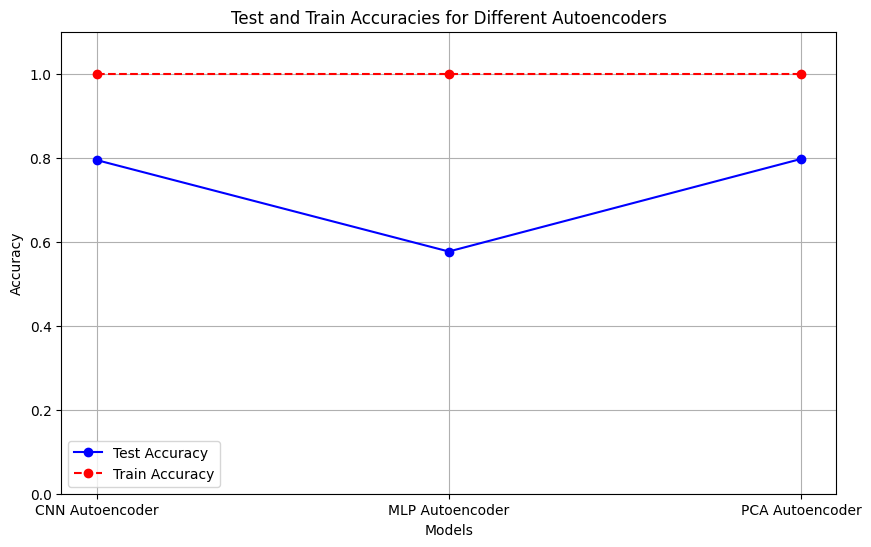

In [12]:
# Arrays of test and train accuracies for each model
test_accuracies = np.array([0.7945, 0.5767, 0.7971])
train_accuracies = np.array([1.0000, 1.0000, 1.0000])

# Model labels
models = ['CNN Autoencoder', 'MLP Autoencoder', 'PCA Autoencoder']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(models, test_accuracies, marker='o', linestyle='-', color='b', label='Test Accuracy')
plt.plot(models, train_accuracies, marker='o', linestyle='--', color='r', label='Train Accuracy')

# Labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test and Train Accuracies for Different Autoencoders')
plt.ylim(0, 1.1)  # Limits the y-axis from 0 to 1.1 for clarity
plt.legend()
plt.grid(True)
plt.savefig("figures/KNN_accuracies_plot.png")
plt.show()


### Performamance comparison

Above accuracy plot matches with the previous comaprisons between these three models. CNN and PCA autoencoders have similar performance and MLP autoencoder has poor performance as comapred to other two. All this holds for validation accuracies. But train accuracy for all of them is 100 %. the reason is for KNN entire traing data is directly used and no feature or pattern extraction in data is prformed. So for any sample in training data it predicts the label with 100 % accuracy. 


Confusion matrices suggest that all three models are good at classifying the classes 1, 3, 8, 9. I think the reason is these 4 classes are very much different from eachother and other remaining classes.